# U13 Abdullah Barhoum (5041774), Katharina Müller (5284090)

# Assignment 13 The last but not the least : RNN

The idea behind RNNs is to make use of sequential information. In a traditional neural network we assume that all inputs (and outputs) are independent of each other. But for many tasks that’s a very bad idea. If you want to predict the next word in a sentence you better know which words came before it. RNNs are called recurrent because they perform the same task for every element of a sequence, with the output being depended on the previous computations. Another way to think about RNNs is that they have a “memory” which captures information about what has been calculated so far. In theory RNNs can make use of information in arbitrarily long sequences, but in practice they are limited to looking back only a few steps (more on this later). Here is what a typical Vanilla RNN looks like:

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/4000/0*WdbXF_e8kZI1R5nQ.png", width=700)

In this, we will not work on images for more simplicity. Instead of that, let's be generative on text, no? One of the classical application of RNN network is to be able to predict the next value given a certain amount of older one. Compare to the previous network, you give t word ($x_t$) and the network output you $x_{t+1}$ (here it's $h_t$)

In [2]:
Image(url= "https://iq.opengenus.org/content/images/2019/12/1_XvUt5wDQA8D3C0wAuxAvbA.png", width=700)

By doing so, could it be able to train a network to be able to write something? Let's try to make a Siliconspears. In the data folder, you have now a shakespear folder containing all the work of William. Your task will be to implement a RNN who learn how to write some shakespear! (it will just sham of course). 

Bellow, you will find all the utilitary code to be able to perform it. The Corpus class is a dataset and you can call a batch with the target by applying get_batch to a batchifyed dataset

In [31]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from torch.autograd import Variable
import torch.cuda as cuda
import torch.optim as optim
import torch.nn.functional as F
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = []

    def add_word(self, word):
        if word not in self.word2idx:
            self.idx2word.append(word)
            self.word2idx[word] = len(self.idx2word) - 1
        return self.word2idx[word]

    def __len__(self):
        return len(self.idx2word)

class Corpus(object):
    def __init__(self, path):
        self.dictionary = Dictionary()
        
        # This is very english language specific
        # We will ingest only these characters:
        self.whitelist = [chr(i) for i in range(32, 127)]
        
        self.train = self.tokenize(os.path.join(path, 'train.txt'))
        self.valid = self.tokenize(os.path.join(path, 'valid.txt'))

    def tokenize(self, path):
        """Tokenizes a text file."""
        assert os.path.exists(path)
        # Add words to the dictionary
        with open(path, 'r',  encoding="utf8") as f:
            tokens = 0
            for line in f:
                line = ''.join([c for c in line if c in self.whitelist])
                words = line.split() + ['<eos>']
                tokens += len(words)
                for word in words:
                    self.dictionary.add_word(word)

        # Tokenize file content
        with open(path, 'r',  encoding="utf8") as f:
            ids = torch.LongTensor(tokens)
            token = 0
            for line in f:
                line = ''.join([c for c in line if c in self.whitelist])
                words = line.split() + ['<eos>']
                for word in words:
                    ids[token] = self.dictionary.word2idx[word]
                    token += 1

        return ids
    
def batchify(data, batch_size):
    # Work out how cleanly we can divide the dataset into bsz parts.
    nbatch = data.size(0) // batch_size
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * batch_size)
    # Evenly divide the data across the bsz batches.
    data = data.view(batch_size, -1).t().contiguous()
    if cuda.is_available():
        data = data.cuda()
    return data

max_seq_len = 200
def get_batch(source, i, evaluation=False):
    seq_len = min(max_seq_len, len(source) - 1 - i)
    if seq_len < max_seq_len:
        return None, None
    data = Variable(source[i:i+seq_len], volatile=evaluation)
    target = Variable(source[i+1:i+1+seq_len].view(-1))
    if cuda.is_available():
        data = data.cuda()
        target = target.cuda()
    return data, target

In [6]:
corpus = Corpus('./data/shakespear')

In [26]:
vocab_len = len(corpus.dictionary)
num_hidden = 100
embedding_dim = 100

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encode = nn.Embedding(vocab_len, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, num_hidden)
        self.decoder = nn.Linear(num_hidden, vocab_len)
        
    def forward(self, x, h):
        embed = F.relu(self.encode(x))
        embed = embed.view(1, -1, embedding_dim)
        rnn_output, h = self.rnn(embed, h)
        rnn_output = F.relu(rnn_output)
        preds = torch.sigmoid(self.decoder(rnn_output))
        #preds = preds.view(-1, vocab_len)
        preds = torch.argmax(preds, 2).view(-1)
        return preds, h

In [33]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters())
# loss_crit = nn.BCELoss()
loss_crit = nn.MSELoss(reduction='mean')

In [36]:
hidden = torch.zeros((1, max_seq_len,  num_hidden)).to(device)
# print(hidden.shape)
losses = []
for i in range(2000):
    data, labels = get_batch(corpus.train, i)
    labels = labels.type(torch.float32)
    preds, hidden = model(data, hidden)
    preds = preds.type(torch.float32)
    loss = loss_crit(preds, labels)
    losses.append(loss.cpu().numpy().item())

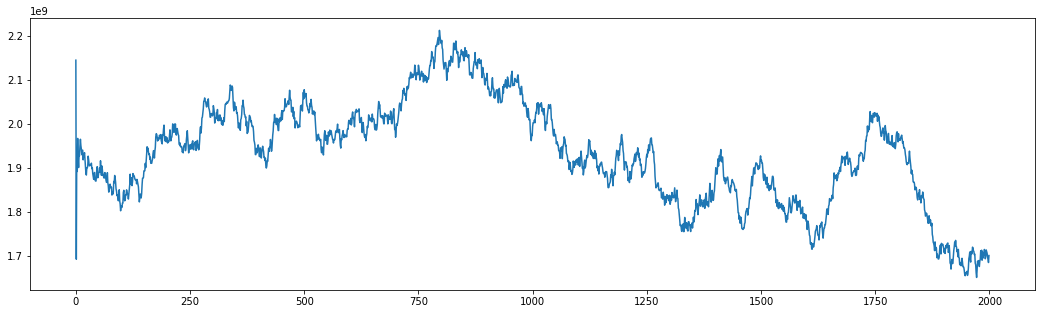

In [38]:
# preds.shape, labels.shape
plt.figure(figsize=(18, 5))
plt.plot(losses);

As we can see from the loss, the model is learning, we choose MSE loss because it was easier to implement than BCE and saved memory, if we train the model longer we expect the model to preform better.